This is our solution for [Analytics Vidhya Hackathon](https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon)

In [ ]:
# Comment this if you are not running in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path, listdir
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import train_test_split

### Defines reusable constants

In [ ]:
# Data files: 
# Google drive: https://drive.google.com/file/d/1Ylz6tmeSjxwg489bs_XZI-kCG9TxQ3mN/view
# Download the above data files from our google drive 
# to your google drive or local computer and update the below paths accordingly

data_path = "/content/drive/MyDrive/ML_Projects/Emergency_Or_Not/data"
models_path = "/content/drive/MyDrive/ML_Projects/Emergency_Or_Not/models"
train_csv_path = path.join(data_path, 'train.csv')
test_csv_path = path.join(data_path, 'test.csv')
label_col = 'emergency_or_not'
image_idx_col = 'image_idx'
image_names_col = 'image_names'
images_dir = path.join(data_path, "images")
imgx = 128
imgy = 128
images_npy_file = path.join(data_path, 'images_{}x{}.npy'.format(imgx, imgy))

Define common functions

In [36]:
def get_image_id(img_name):
    return int(img_name[:-4])

def get_image(img_name):
    img_path = path.join(images_dir, img_name)
    return Image.open(img_path)

# Shows a randomly selected images from data
def showImages(df, n=1):
    cols = 5
    rows = max(1, n//cols)
    sample = df.sample(n=n).reset_index(drop=True)
    for idx, row in sample.iterrows():
      img = get_image(row[image_names_col])
      plt.subplot(rows, cols, idx+1)
      plt.title(row[label_col])
      plt.imshow(img)
    plt.figure(figsize=(10, 20))
    plt.show()

# Saves images as numpy array for faster training cycles
def save_images_as_numpy_array(images_dir=images_dir, newx=imgx, newy=imgy):
    if path.exists(images_npy_file):
      print("File exists so skipping")
      return
    files = listdir(images_dir)
    images_arr = np.zeros((len(files), newx, newy, 3))
    for fname in files:
        img = get_image(fname)
        img_id = get_image_id(fname)
        images_arr[img_id] = np.array(img.resize((newx, newy))).astype(np.uint8)
    with open(images_npy_file, 'wb') as f:
        np.save(f, images_arr)

# Creates tensorflow dataset for images
def create_image_dataset(df):
    def extract_image(img_id):
        return tf.cast(all_images_tensor[img_id]/255, tf.float32)
    
    ds = tf.data.Dataset.from_tensor_slices(df[image_idx_col].values)
    ds = ds.map(extract_image)
    return ds.prefetch(tf.data.AUTOTUNE)

# Creates tensorflow dataset for images and their labels
def create_dataset_with_labels(df):
    img_ds = create_image_dataset(df)
    labels_ds = tf.data.Dataset.from_tensor_slices(df[label_col].values)
    return tf.data.Dataset.zip((img_ds, labels_ds)).batch(32)

Generate npy files of all images after resizing to given (imgx, imgy) dimensions

In [ ]:
save_images_as_numpy_array()

File exists so skipping


### Load data

In [ ]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
with open(images_npy_file, 'rb') as f:
    all_images_tensor = tf.constant(np.load(f))

### Prepare datasets for training and validation

In [ ]:
train_data, val_data = train_test_split(train_df, test_size=0.2)
train_ds = create_dataset_with_labels(train_data)
val_ds = create_dataset_with_labels(val_data)
test_ds = create_image_dataset(test_df).batch(32)

### Training deep neaural network using Tensorflow

**Transfer learning**: We are using MobileNet model for image classification

In [ ]:
mnet = mobilenet_v2.MobileNetV2(include_top=False, pooling='max', 
                                weights='imagenet', input_shape=(imgy, imgx, 3))
def create_model():
    model = Sequential([
        mnet,
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    model.layers[0].trainable=False
    return model

def compile_and_fit(model, train_ds, val_ds, model_path, epochs=5, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, mode='max')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_accuracy', factor=0.1, patience=patience,
                                                     mode='max', min_delta=0.0001, cooldown=0, min_lr=0.0001)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                                                   mode='max', save_weights_only=True,
                                                                   save_best_only=True)
    
    model.compile(loss="binary_crossentropy", metrics=["accuracy"],
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01))
    return model.fit(train_ds, epochs=epochs, validation_data=val_ds,
                      callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])


9420800/9406464 [==============================] - 0s 0us/step


In [9]:
model = create_model()
print(model.summary())
models_dir = path.join(models_path, "base")
model_path = path.join(models_dir, "best")
# model.load_weights(tf.train.latest_checkpoint(models_dir))
compile_and_fit(model, train_ds, val_ds, model_path, epochs=30, patience=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/30
42/42 [==============================] - 27s 578ms/step - loss: 0.5937 - accuracy: 0.8457 - val_loss: 0.5014 - val_accuracy: 0.8758 - lr: 0.0100
Epoch 2/30
42/42 [==============================] - 20s 472ms/step - loss: 0.28

#### Check results on test dataset

In [40]:
# Create best model from saved weights
best_model = create_model()
best_model.load_weights(tf.train.latest_checkpoint(models_dir))
test_predictions = best_model.predict(test_ds)
test_df[label_col] = (test_predictions>0.5).astype(np.uint0)

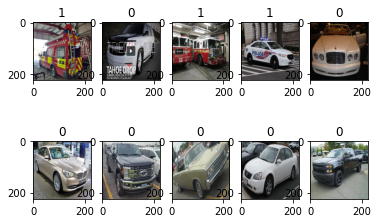

<Figure size 720x1440 with 0 Axes>

In [41]:
showImages(test_df, n=10)

Looks like our model is performing well on test set as well